In [1]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pystan
from theano import tensor as tt
import pymc3
import re
import scipy.stats as stats
import json
import matplotlib.pylab as pl

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def exponential_cov(x, y, *args):
    assert len(args) >= 2, "need more 2 or more params for exponential kernel, got %i"%(len(args))
    return args[0] * np.exp( -0.5 * args[1] * np.subtract.outer(x, y)**2)

In [3]:
def conditional(x_new, x, y, params):
    
    B = exponential_cov(x_new, x, *params)
    C = exponential_cov(x, x, *params)
    A = exponential_cov(x_new, x_new, *params)

    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))

    return(mu.squeeze(), sigma.squeeze())

In [6]:
xpts = np.linspace(-15, 5, num=1000)
XX = np.zeros(shape=(len(xpts), len(xpts)), dtype=np.float64)
theta = [1,2]

for i, row in enumerate(XX):
    for j, col in enumerate(row):
        
        XX[i,j] = exponential_cov(xpts[i], xpts[j], *theta)

In [7]:
process = stats.multivariate_normal(np.zeros_like(xpts), XX, allow_singular=True)

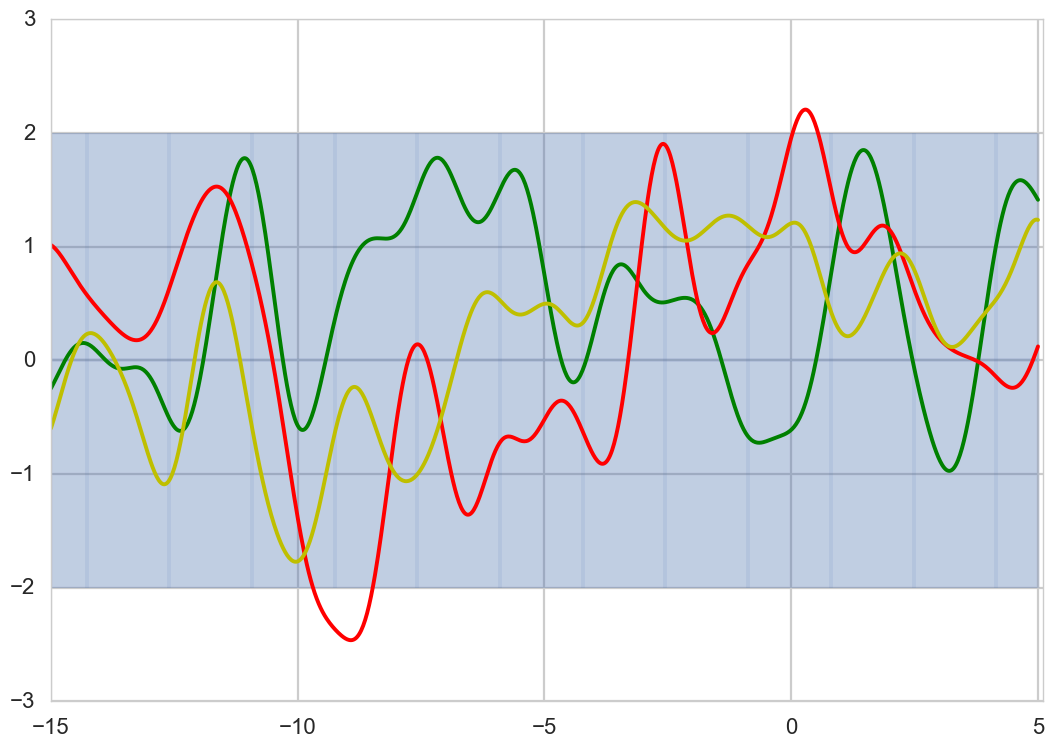

In [8]:
theta = [1, 2]
sig_0 = exponential_cov(0, 0, *theta)

pl.errorbar(xpts, np.zeros(len(xpts)), yerr=2*sig_0, capsize=0, alpha=0.1)
plt.ylim([-3,3])
plt.xlim([-15,5.1])

# make three draws from the prior_predictive

vec1 = process.rvs()
vec2 = process.rvs()
vec3 = process.rvs()

plt.plot(xpts, vec1, c='g')
plt.plot(xpts, vec2, c='r')
plt.plot(xpts, vec3, c='y')

plt.show()

# now observe the data

In [9]:
data = [[-4,-2],[-3,0],[-1,1],[0,2],[2,-1]]

In [10]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, *params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, *params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

sig_1 = exponential_cov([d[0] for d in data], [d[0] for d in data], *theta)
x_pred = np.linspace(-15, 5, 1000)
predictions = [predict(i, [d[0] for d in data], exponential_cov, theta, sig_1, [d[1] for d in data]) for i in x_pred]

In [11]:
# sig_1 = exponential_cov([d[0] for d in data], [d[0] for d in data], *theta)
# Sinv = np.linalg.inv(sig_1)

# def predict_(x1, x2, data, kernel, params, Sinv, t):
#     k1 = np.array([kernel(x1, y, *params) for y in data]) 
#     k2 = np.array([kernel(x2, y, *params) for y in data])
#     y_pred = np.dot(k1, Sinv).dot(t) + np.dot(k2, Sinv).dot(t)
#     sigma_new = kernel(x1, x2, *params) - np.dot(k1, Sinv).dot(k2)
#     return y_pred, sigma_new

In [12]:
# mX = np.zeros(shape=(len(x_pred)))
# sXX = np.zeros(shape=(len(x_pred), len(x_pred)), dtype=np.float64)

# for i, row in enumerate(sXX):
#     for j, col in enumerate(row):
        
#         pred_ = predict_(x_pred[i], x_pred[j], [d[0] for d in data], exponential_cov, theta, Sinv, [d[1] for d in data])
#         sXX[i,j] = pred_[1]
        
#         if i == j:
#             mX[i] = pred_[0]

In [13]:
# process = stats.multivariate_normal(mX, sXX, allow_singular=True)

In [14]:
predictions

[(-6.51821226310154e-53, 1.0),
 (-1.0121276424433328e-52, 1.0),
 (-1.5703408985776622e-52, 1.0),
 (-2.434470217561993e-52, 1.0),
 (-3.771089663470618e-52, 1.0),
 (-5.836884770020276e-52, 1.0),
 (-9.027079127686356e-52, 1.0),
 (-1.3949712193488703e-51, 1.0),
 (-2.153947502166109e-51, 1.0),
 (-3.323202831550842e-51, 1.0),
 (-5.1230719215107957e-51, 1.0),
 (-7.891433933824907e-51, 1.0),
 (-1.2145999688248522e-50, 1.0),
 (-1.8679380757160582e-50, 1.0),
 (-2.8704074754627995e-50, 1.0),
 (-4.40733942671772e-50, 1.0),
 (-6.761784307138466e-50, 1.0),
 (-1.0365684743669937e-49, 1.0),
 (-1.5877661831563025e-49, 1.0),
 (-2.4301157941630994e-49, 1.0),
 (-3.716372661986277e-49, 1.0),
 (-5.67888944222942e-49, 1.0),
 (-8.670805401142756e-49, 1.0),
 (-1.3228400455919789e-48, 1.0),
 (-2.016541184712318e-48, 1.0),
 (-3.0715580485755665e-48, 1.0),
 (-4.674791298418041e-48, 1.0),
 (-7.109148647178206e-48, 1.0),
 (-1.0802513848485545e-47, 1.0),
 (-1.6401513919560685e-47, 1.0),
 (-2.488255143568739e-47, 1.0

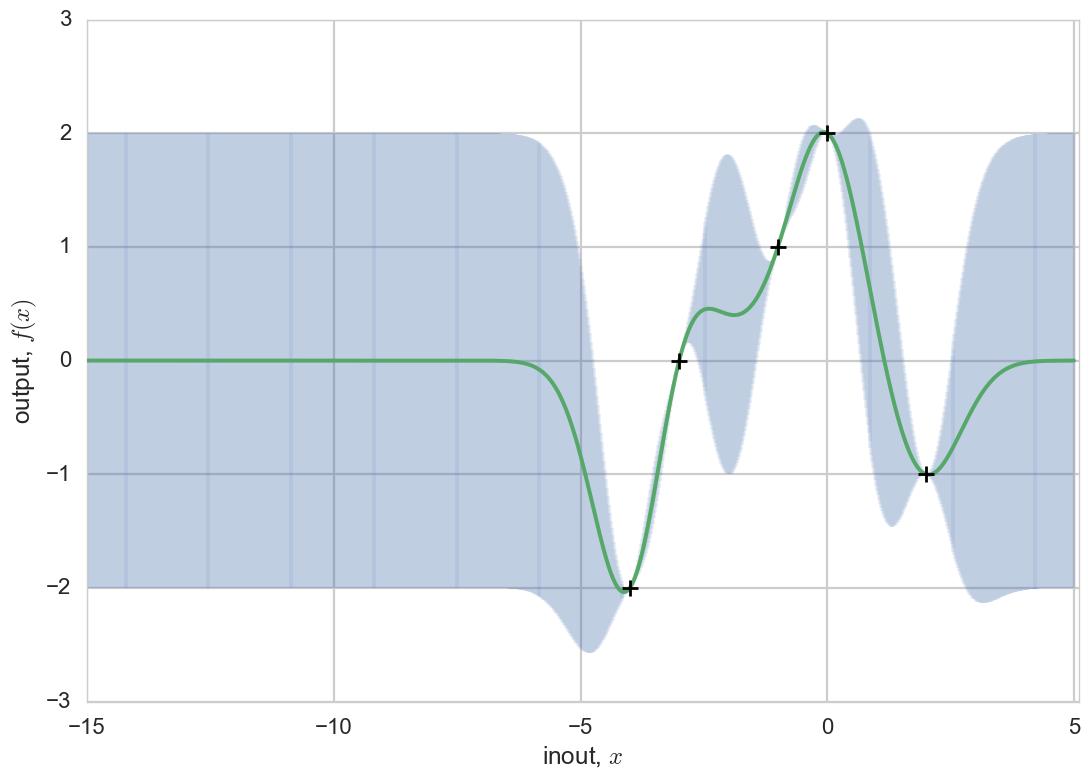

In [15]:
pl.errorbar(x_pred, [predictions[i][0] for i in range(len(predictions))], yerr=[2*predictions[i][1] for i in range(len(predictions))], capsize=0, alpha=0.1)
plt.plot(x_pred, [predictions[i][0] for i in range(len(predictions))], zorder=100)

plt.scatter([d[0] for d in data], [d[1] for d in data], marker='+', lw=2, s=120, zorder=200, c='black')

plt.ylim([-3,3])
plt.xlim([-15,5.1])

# make three draws from the prior_predictive

# vec1 = process.rvs()
# vec2 = process.rvs()
# vec3 = process.rvs()

# plt.plot(xpts, vec1, c='g')
# plt.plot(xpts, vec2, c='r')
# plt.plot(xpts, vec3, c='y')

plt.xlabel('inout, $x$')
plt.ylabel('output, $f(x)$')
plt.show()